# Data

In [76]:
# load the packages
from pyimagesearch import config
from pyimagesearch import top
from pyimagesearch.resnet import ResNet
from imutils import paths
import random
import shutil
import os
import cv2
import re
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras import optimizers
from keras.applications import VGG16
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

sns.set_style('white')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
SEED = 42

## Load Item Data

In [3]:
# import item
items = pd.read_csv("data/Taobao Clothes Matching Data/dim_items（new).txt", sep='delimiter', header=None)
items = items[0].apply(lambda x: x.split())
item_df = pd.DataFrame()
item_df['item_id'] = items.apply(lambda x: x[0])
item_df['cat_id'] = items.apply(lambda x: x[1])
item_df['terms'] = items.apply(lambda x: x[2:])
item_df.head()

,item_id,cat_id,terms
0,29,155,"[123950,53517,106068,59598,7503,171811,25618,1..."
1,49,228,"[73035,33202,116593,48909,92233,181255,127004,..."
2,59,284,"[123950,38910,22837,5026,15459,47776,158346,10..."
3,109,461,"[122071,35420,123950,27207,116593,24893,31897,..."
4,119,368,"[48909,125706,116593,179606,20819,158346,15722..."


In [4]:
item_df.shape

(499983, 3)

In [5]:
# number of categories
item_df.cat_id.nunique()

281

In [6]:
top_cat = item_df.cat_id.value_counts()[:20]
top_cat

368    59380
52     41859
284    32080
461    28388
111    27604
505    19985
48     19348
155    17720
228    17617
160    15930
137    15735
33     15638
42     15003
516    13285
50     12451
453    10865
178    10146
81      9050
311     8895
522     7878
Name: cat_id, dtype: int64

In [7]:
top_item_df = item_df.loc[item_df.cat_id.isin(top_cat.index), ['item_id', 'cat_id']]
top_item_df.shape

(398857, 2)

In [16]:
top_item = list(top_item_df.item_id)

## Filter Image

Filter for items in the top 20 categories.

In [9]:
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = 'data/tianchi_fm_img2_1'

# initialize the base path to the *new* directory that will contain our images after computing the training and testing split
BASE_PATH = 'data'

# filter path
FILTER_PATH = os.path.sep.join([BASE_PATH, 'filter'])

# create the directory
if not os.path.exists(top.FILTER_PATH):
        print("[INFO] 'creating {}' directory".format(top.FILTER_PATH))
        os.makedirs(top.FILTER_PATH)

In [30]:
# loop over the input image paths
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))

for inputPath in imagePaths:

    # extract the filename of the input image along with its corresponding class label
    filename = inputPath.split(os.path.sep)[-1]
    file_id = filename.split('.')[0]
    if file_id in top_item:
        label = top_item_df.loc[top_item_df.item_id==file_id, 'cat_id'].values[0]
        # build the path to the label directory
        labelPath = os.path.sep.join([top.FILTER_PATH, label])

        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)

        # construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] 'creating data/filter/284' directory
[INFO] 'creating data/filter/48' directory
[INFO] 'creating data/filter/33' directory
[INFO] 'creating data/filter/461' directory
[INFO] 'creating data/filter/50' directory
[INFO] 'creating data/filter/178' directory
[INFO] 'creating data/filter/311' directory
[INFO] 'creating data/filter/81' directory
[INFO] 'creating data/filter/160' directory
[INFO] 'creating data/filter/368' directory
[INFO] 'creating data/filter/42' directory
[INFO] 'creating data/filter/52' directory
[INFO] 'creating data/filter/155' directory
[INFO] 'creating data/filter/228' directory
[INFO] 'creating data/filter/505' directory
[INFO] 'creating data/filter/522' directory
[INFO] 'creating data/filter/453' directory
[INFO] 'creating data/filter/111' directory
[INFO] 'creating data/filter/516' directory
[INFO] 'creating data/filter/137' directory


## Train, Val, Test Split

In [2]:
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = 'data/filter'

# initialize the base path to the *new* directory that will contain our images after computing the training and testing split
BASE_PATH = 'data'

# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, 'training'])
VAL_PATH = os.path.sep.join([BASE_PATH, 'validation'])
TEST_PATH = os.path.sep.join([BASE_PATH, 'testing'])

# define the amount of data that will be used training
TRAIN_SPLIT = 0.8

# the amount of validation data will be a percentage of the *training* data
VAL_SPLIT = 0.1

In [3]:
# grab the paths to all input images in the original input directory and shuffle them
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

In [4]:
# compute the training and testing split
i = int(len(imagePaths) * config.TRAIN_SPLIT)
trainPaths = imagePaths[:i] # 80% of the data
testPaths = imagePaths[i:] # 20% of the data

# we'll be using part of the training data for validation
i = int(len(trainPaths) * config.VAL_SPLIT)
valPaths = trainPaths[:i] # 8% of the data
trainPaths = trainPaths[i:] #72% of the data

In [5]:
# define the datasets that we'll be building
datasets = [
    ('training', trainPaths, config.TRAIN_PATH),
    ('validation', valPaths, config.VAL_PATH),
    ('testing', testPaths, config.TEST_PATH)
]

In [6]:
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
    
    # show which data split we are creating
    print("[INFO] building '{}' split".format(dType))
    
    # if the output base output directory does not exist, create it
    if not os.path.exists(baseOutput):
        print("[INFO] 'creating {}' directory".format(baseOutput))
        os.makedirs(baseOutput)
        
    # loop over the input image paths
    for inputPath in imagePaths:
        
        # extract the filename of the input image along with its corresponding class label
        filename = inputPath.split(os.path.sep)[-1]
        label = inputPath.split(os.path.sep)[-2]

        # build the path to the label directory
        labelPath = os.path.sep.join([baseOutput, label])

        # if the label output directory does not exist, create it
        if not os.path.exists(labelPath):
            print("[INFO] 'creating {}' directory".format(labelPath))
            os.makedirs(labelPath)
            
        # construct the path to the destination image and then copy the image itself
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputPath, p)

[INFO] building 'training' split
[INFO] 'creating data/training' directory
[INFO] 'creating data/training/228' directory
[INFO] 'creating data/training/516' directory
[INFO] 'creating data/training/52' directory
[INFO] 'creating data/training/284' directory
[INFO] 'creating data/training/461' directory
[INFO] 'creating data/training/42' directory
[INFO] 'creating data/training/522' directory
[INFO] 'creating data/training/48' directory
[INFO] 'creating data/training/50' directory
[INFO] 'creating data/training/155' directory
[INFO] 'creating data/training/368' directory
[INFO] 'creating data/training/178' directory
[INFO] 'creating data/training/137' directory
[INFO] 'creating data/training/111' directory
[INFO] 'creating data/training/311' directory
[INFO] 'creating data/training/160' directory
[INFO] 'creating data/training/81' directory
[INFO] 'creating data/training/505' directory
[INFO] 'creating data/training/453' directory
[INFO] 'creating data/training/33' directory
[INFO] buil

In [7]:
# determine the total number of image paths in training, validation, and testing directories
totalTrain = len(list(paths.list_images(config.TRAIN_PATH)))
totalVal = len(list(paths.list_images(config.VAL_PATH)))
totalTest = len(list(paths.list_images(config.TEST_PATH)))

print(totalTrain)
print(totalVal)
print(totalTest)

68904
7655
19140


In [10]:
def load_images(folder):
    images = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images[filename.split('.')[0]] = img
    return images

In [11]:
train_228 = load_images('data/training/228')

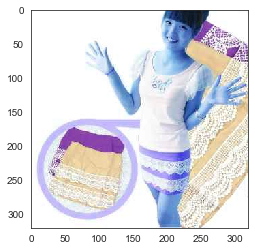

In [13]:
plt.imshow(train_228[list(train_228.keys())[0]])

## Baseline

In [15]:
# initialize the training training data augmentation object
trainAug = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=90,
    zoom_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1/255.0)

In [16]:
batch_size = 20

# initialize the training generator
trainGen = trainAug.flow_from_directory(
    config.TRAIN_PATH,
    class_mode="sparse",
    target_size=(150, 150),
    batch_size=batch_size)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    config.VAL_PATH,
    class_mode="sparse",
    target_size=(150, 150),
    batch_size=batch_size)
# initialize the testing generator
testGen = valAug.flow_from_directory(
    config.TEST_PATH,
    class_mode="sparse",
    target_size=(150, 150),
    batch_size=batch_size)

Found 68904 images belonging to 20 classes.
Found 7655 images belonging to 20 classes.
Found 19140 images belonging to 20 classes.


In [17]:
conv_base = VGG16(weights="imagenet", include_top=False)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [18]:
# Use the following code to extract the features and labels
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if ((i * batch_size % 1000) == 0 ):
            print("processed size =", i * batch_size)
        if i * batch_size >= sample_count:
            break
    return features, labels

In [19]:
train_features, train_labels = extract_features(trainGen, totalTrain)
validation_features, validation_labels = extract_features(valGen, totalVal)
test_features, test_labels = extract_features(testGen, totalTest)
train_features = np.reshape(train_features, (totalTrain, 4*4*512))
validation_features = np.reshape(validation_features, (totalVal, 4*4*512))
test_features = np.reshape(test_features, (totalTest, 4*4*512))

processed size = 1000
processed size = 2000
processed size = 3000
processed size = 4000
processed size = 5000
processed size = 6000
processed size = 7000
processed size = 8000
processed size = 9000
processed size = 10000
processed size = 11000
processed size = 12000
processed size = 13000
processed size = 14000
processed size = 15000
processed size = 16000
processed size = 17000
processed size = 18000
processed size = 19000
processed size = 20000
processed size = 21000
processed size = 22000
processed size = 23000
processed size = 24000
processed size = 25000
processed size = 26000
processed size = 27000
processed size = 28000
processed size = 29000
processed size = 30000
processed size = 31000
processed size = 32000
processed size = 33000
processed size = 34000
processed size = 35000
processed size = 36000
processed size = 37000
processed size = 38000
processed size = 39000
processed size = 40000
processed size = 41000
processed size = 42000
processed size = 43000
processed size = 440

In [20]:
np.save('train_features', train_features)
np.save('val_features', validation_features)
np.save('test_features', test_features)
np.save('train_labels', train_labels)
np.save('val_labels', validation_labels)
np.save('test_labels', test_labels)

In [62]:
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 68904 samples, validate on 7655 samples
Epoch 1/20
68904/68904 [==============================] - 128s 2ms/step - loss: 2.6891 - accuracy: 0.2035 - val_loss: 2.2511 - val_accuracy: 0.3265
Epoch 2/20
68904/68904 [==============================] - 81s 1ms/step - loss: 2.4321 - accuracy: 0.2690 - val_loss: 2.0623 - val_accuracy: 0.3594
Epoch 3/20
68904/68904 [==============================] - 83s 1ms/step - loss: 2.3229 - accuracy: 0.2923 - val_loss: 1.9651 - val_accuracy: 0.3880
Epoch 4/20
68904/68904 [==============================] - 78s 1ms/step - loss: 2.2558 - accuracy: 0.3116 - val_loss: 1.9083 - val_accuracy: 0.4097
Epoch 5/20
68904/68904 [==============================] - 80s 1ms/step - loss: 2.2062 - accuracy: 0.3240 - val_loss: 1.8842 - val_accuracy: 0.4101
Epoch 6/20
68904/68904 [==============================] - 85s 1ms/step - loss: 2.1681 - accuracy: 0.3345 - val_loss: 1.8729 - val_accuracy: 0.4119
Epoch 7/20
68904/68904 [==============================] - 102s 1ms/s

In [63]:
accuracy = model.evaluate(test_features, test_labels, batch_size=batch_size)
print("Accuracy: ", accuracy[1])

19140/19140 [==============================] - 8s 408us/step
Accuracy:  0.4356844425201416


Accuracy: 0.435737
Precision: 0.435737
Recall: 0.435737
F1 score: 0.435737
Cohens kappa: 0.388313
ROC AUC: 0.869332
              precision    recall  f1-score   support

         0.0       0.71      0.80      0.76      1246
         1.0       0.54      0.52      0.53       682
         2.0       0.53      0.41      0.46       853
         3.0       0.21      0.19      0.20       736
         4.0       0.20      0.13      0.16       510
         5.0       0.60      0.35      0.44       869
         6.0       0.65      0.67      0.66      1534
         7.0       0.19      0.19      0.19       449
         8.0       0.07      0.00      0.01       787
         9.0       0.43      0.59      0.50      2834
        10.0       0.23      0.13      0.17       727
        11.0       0.09      0.02      0.04       539
        12.0       0.47      0.46      0.47      1397
        13.0       0.64      0.64      0.64       947
        14.0       0.37      0.24      0.29       557
        15.0       

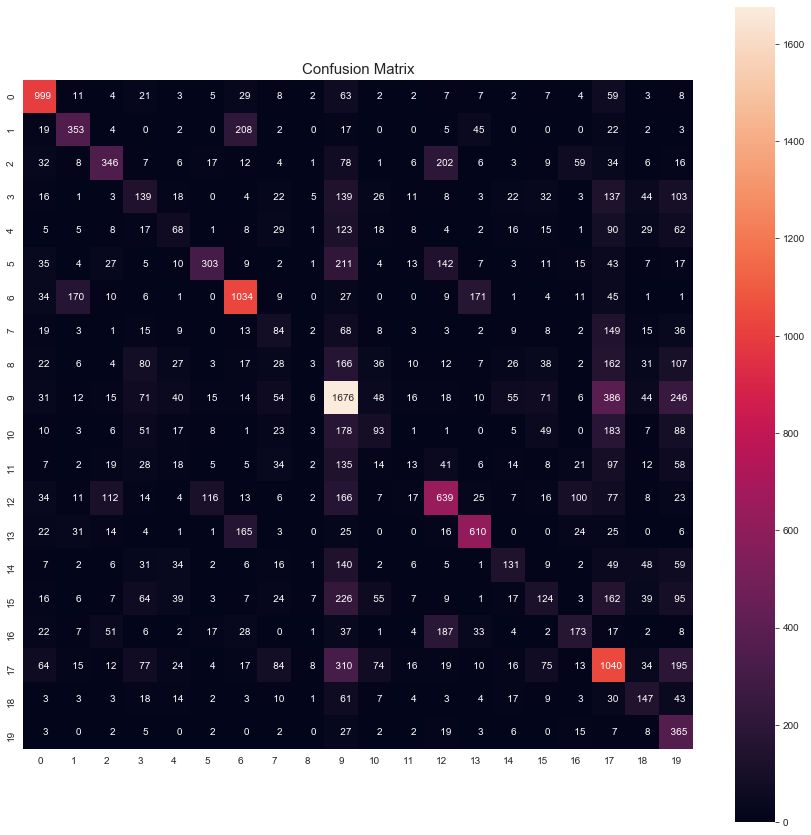

In [64]:
# predict probabilities for test set
yhat_probs = model.predict(test_features, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(test_features, verbose=0)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, yhat_classes, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, yhat_classes, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, yhat_classes, average='micro')
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(test_labels, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(test_labels, yhat_probs, multi_class='ovr')
print('ROC AUC: %f' % auc)

# classification report
print(classification_report(test_labels, yhat_classes))

# visualize the confusion matrix
matrix = confusion_matrix(test_labels, yhat_classes)
plt.figure(figsize=(15, 15))
sns.heatmap(matrix, square=True, annot=True, fmt='5g')
plt.title('Confusion Matrix', fontsize=15)
plt.show()

Many classes misclassified as class 9, 17 and 19. Most 0s, and 19s are classified correctly. While some 1s and 13s are misclassified as 6s, and some 2s, 5s, and 16s are misclassied as 12s.

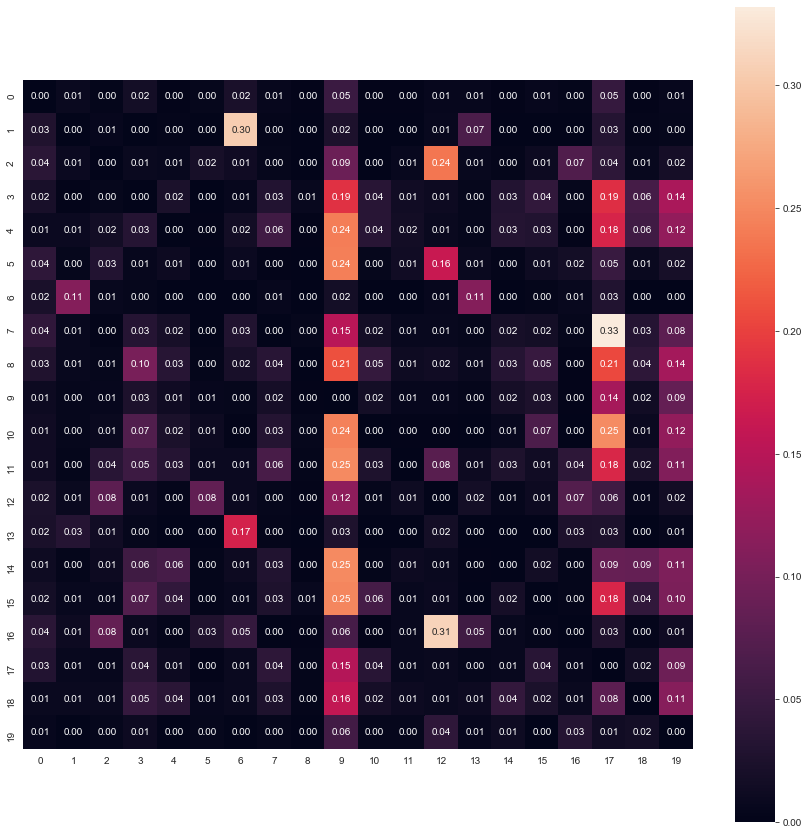

In [68]:
# normalized confusion matrix
# rows: actual classes, columns: predicted classes
row_sums = matrix.sum(axis=1, keepdims=True) 
norm_conf_mx = matrix / row_sums

plt.figure(figsize=(15, 15))
np.fill_diagonal(norm_conf_mx, 0) 
sns.heatmap(norm_conf_mx, square=True, annot=True, fmt='.2f') 
plt.show()

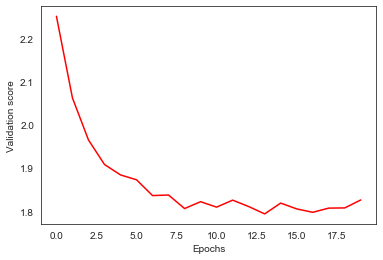

In [65]:
# create the plot of the validation loss to compare different models
plt.plot(history.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()